# Echopype: NASC - Nautical Area Scattering Coefficient - $m^2 nmi^{-2}$

In [1]:
import os
import subprocess
from pathlib import Path
from typing import List, Optional, Union, Tuple

import pytest
import numpy as np
import ipytest
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

import echopype as ep
import echopype.utils
import echopype.visualize as epviz
from echopype import open_raw
from echopype.calibrate import compute_Sv
from echopype.commongrid import compute_NASC
from echopype.commongrid.nasc import (
    get_distance_from_latlon,
    get_depth_bin_info,
    get_dist_bin_info,
)
from echopype.consolidate import add_location, add_depth
from echopype.testing import TEST_DATA_FOLDER


**Read a test EK60 .raw file**

In [2]:
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170620-T011027.raw"
s3raw_fpath = f"s3://{bucket}/{rawdirpath}"
ed = ep.open_raw(s3raw_fpath, sonar_model='EK60', storage_options={'anon': True})
# Manually populate additional metadata about the dataset and the platform
# -- SONAR-netCDF4 Top-level Group attributes
ed['Top-level'].attrs['title'] = "2017 Pacific Hake Acoustic Trawl Survey"
ed['Top-level'].attrs['summary'] = (
    f"EK60 raw file {s3raw_fpath} from the {ed['Top-level'].attrs['title']}, "
    "converted to a SONAR-netCDF4 file using echopype."
)
# -- SONAR-netCDF4 Platform Group attributes
ed['Platform'].attrs['platform_type'] = "Research vessel"
ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"
ed['Platform'].attrs['platform_code_ICES'] = "315"

**Display corresponding EchoData object.**
- Note that the `Platform` group contains latitude and longitude values for the platform

In [3]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.


**Add geographical location (latitude/longitude) to the Sv dataset.**

**Create a depth data variable based on data in Sv dataset.**

- The `depth` is generated based on whether the transducers are mounted vertically or with a polar angle to vertical, and whether the transducers were pointed up or down.

In [4]:
ds_Sv = add_depth(add_location(compute_Sv(ed), ed, nmea_sentence="GGA"))

**Analyze the dataset that contains Sv, geographical location, and depth.**

In [5]:
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 1932,
                                    range_sample: 1055, filenames: 1,
                                    time3: 1932)
Coordinates:
  * channel                        (channel) object 'GPT  18 kHz 009072058c8d...
  * ping_time                      (ping_time) datetime64[ns] 2017-06-20T01:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 1052 1053 1054
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-06-20T01:10:27...
Data variables: (12/19)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.83 ... -0.34
    ...                             ...
    beamwidth_athwartship          (channel, ping_time) float64 10.3 ... 7.2
    source_filenames               (filenames) <U92 's3://ncei-wcsd-archive/d...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
    latitude                       (ping_time) float64 nan 44.71 ... 44.7 44.7
    longitude                      (ping_time) float64 nan -124.3 ... -124.4
    depth                          (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-25T09:20:16Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

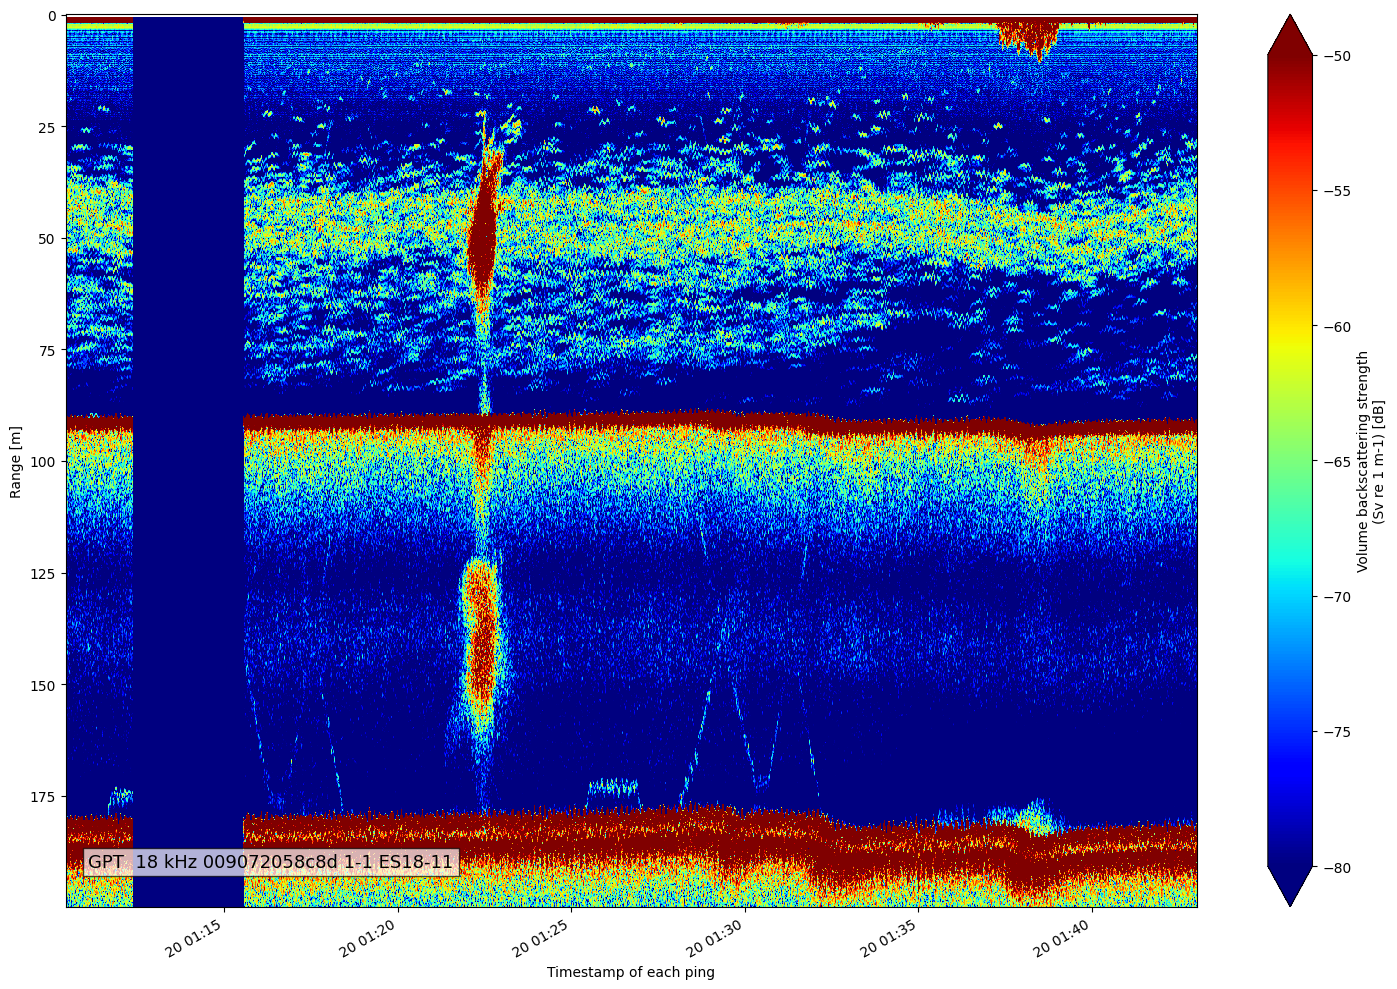

In [6]:
epviz.create_echogram(ds_Sv, channel='GPT  18 kHz 009072058c8d 1-1 ES18-11', vmin=-80, vmax=-50)

**Set `cell_dist` and `cell_depth`**

- `cell_dist`: The horizontal size of each NASC cell, in nautical miles [nmi]
- `cell_depth`: The vertical size of each NASC cell, in meters [m]

In [7]:
cell_dist = 0.1
cell_depth = 20

**Compute and test NASC**

In [8]:
ds_NASC = compute_NASC(ds_Sv, cell_dist, cell_depth)

dist_nmi = get_distance_from_latlon(ds_Sv)

# Check dimensions
da_NASC = ds_NASC["NASC"]
assert da_NASC.dims == ("channel", "distance", "depth")
assert np.all(ds_NASC["channel"].values == ds_Sv["channel"].values)
assert da_NASC["depth"].size == np.ceil(ds_Sv["depth"].max() / cell_depth)
assert da_NASC["distance"].size == np.ceil(dist_nmi.max() / cell_dist)

ds_NASC

<xarray.Dataset>
Dimensions:            (channel: 3, distance: 7, depth: 10)
Coordinates:
  * channel            (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11...
  * distance           (distance) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6
  * depth              (depth) float64 0.0 20.0 40.0 60.0 ... 140.0 160.0 180.0
Data variables:
    NASC               (channel, distance, depth) float64 0.04834 ... 0.0002618
    frequency_nominal  (channel) float64 1.8e+04 3.8e+04 1.2e+05
Attributes:
    Conventions:          CF-1.7,ACDD-1.3
    time_coverage_start:  2017-06-20T01:10:27.136999936Z
    time_coverage_end:    2017-06-20T01:43:01.045000192Z
    geospatial_lat_min:   44.70332
    geospatial_lat_max:   44.70792
    geospatial_lon_min:   -124.35596
    geospatial_lon_max:   -124.34304

In [9]:
ds_NASC['NASC'].values.max()

3.1311214882191276

-------------

**Understand the echopype NASC function step by step.**

In [10]:
ds_Sv = add_depth(add_location(compute_Sv(ed), ed, nmea_sentence="GGA"))
ds_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 1932,
                                    range_sample: 1055, filenames: 1,
                                    time3: 1932)
Coordinates:
  * channel                        (channel) object 'GPT  18 kHz 009072058c8d...
  * ping_time                      (ping_time) datetime64[ns] 2017-06-20T01:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 1052 1053 1054
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2017-06-20T01:10:27...
Data variables: (12/19)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 1.8e+04 3.8e+04 1.2e+05
    sound_speed                    (channel, ping_time) float64 1.481e+03 ......
    sound_absorption               (channel, ping_time) float64 0.002822 ... ...
    sa_correction                  (ping_time, channel) float64 -0.83 ... -0.34
    ...                             ...
    beamwidth_athwartship          (channel, ping_time) float64 10.3 ... 7.2
    source_filenames               (filenames) <U92 's3://ncei-wcsd-archive/d...
    water_level                    (channel, time3) float64 9.15 9.15 ... 9.15
    latitude                       (ping_time) float64 nan 44.71 ... 44.7 44.7
    longitude                      (ping_time) float64 nan -124.3 ... -124.4
    depth                          (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-25T09:20:20Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [11]:
ds_Sv['Sv']

<xarray.DataArray 'Sv' (channel: 3, ping_time: 1932, range_sample: 1055)>
array([[[         nan,          nan,          nan, ..., -67.91910638,
         -76.29392377, -73.5682699 ],
        [         nan,          nan,          nan, ..., -69.17732324,
         -78.2341551 , -76.26107996],
        [         nan,          nan,          nan, ..., -68.03669824,
         -64.46438734, -67.72405451],
        ...,
        [         nan,          nan,          nan, ..., -65.50851526,
         -61.88916914, -61.50354975],
        [         nan,          nan,          nan, ..., -65.62610711,
         -74.82405225, -69.79363459],
        [         nan,          nan,          nan, ..., -76.66779413,
         -70.09694044, -69.72308558]],

       [[         nan,          nan,          nan, ..., -73.38163362,
         -78.19081199, -75.68591131],
        [         nan,          nan,          nan, ..., -82.2243918 ,
         -76.79149711, -86.19844641],
        [         nan,          nan,          nan, ..., -75.25131593,
         -74.15747916, -73.80447973],
...
        [         nan,          nan,          nan, ..., -68.00777803,
         -69.91249168, -73.36939062],
        [         nan,          nan,          nan, ..., -79.74324403,
         -80.23687827, -73.67512335],
        [         nan,          nan,          nan, ..., -79.89611421,
         -85.29323661, -80.31895269]],

       [[         nan,          nan,          nan, ..., -76.71361141,
         -77.64547284, -76.15497885],
        [         nan,          nan,          nan, ..., -85.42702083,
         -77.11631329, -75.56702719],
        [         nan,          nan,          nan, ..., -90.77736263,
         -79.73856671, -79.92960654],
        ...,
        [         nan,          nan,          nan, ..., -70.68124752,
         -70.91932233, -71.60425864],
        [         nan,          nan,          nan, ..., -64.46075801,
         -66.14518292, -67.15935813],
        [         nan,          nan,          nan, ..., -78.95958309,
         -77.99824078, -79.71795188]]])
Coordinates:
  * channel       (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ......
  * ping_time     (ping_time) datetime64[ns] 2017-06-20T01:10:27.136999936 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 1050 1051 1052 1053 1054
Attributes:
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB
    actual_range:  [-206.93, 9.26]

--------------

In [12]:
'''
get_distance_from_latlon()
    Get distance from lat/lon in nautical miles
    
    This function takes an xarray Dataset with Sv data, extracts the latitude and longitude information, 
    computes the distance traveled between consecutive points in nautical miles, 
    and then calculates the cumulative distance.
    The returned value is the cumulative distance for each data point in the input Dataset.

    When the function computes the distance between consecutive latitude and longitude points, 
    it's essentially determining how far the device has traveled between each "ping" (or measurement).

    By then taking the cumulative sum of these individual distances, 
    the function provides the total distance traveled from the start (the first ping) 
    to any given point (or ping_time) in the sequence.
'''
dist_nmi = get_distance_from_latlon(ds_Sv)
dist_nmi

array([5.12096482e-04, 5.12096482e-04, 1.03574966e-03, ...,
       6.79135988e-01, 6.79632380e-01, 6.79632380e-01])

In [13]:
dist_nmi.shape

(1932,)

------

In [14]:
'''
get_dist_bin_info()
    The function get_dist_bin_info takes an array of distances and a desired bin size. 
    It returns the number of bins required to cover the range of distances 
    and an array of bin indices corresponding to each distance.
    
    Example:
    -------
    If:
    
    dist_nmi is [1, 3, 4, 7, 8, 10] (these could be cumulative distances in nautical miles)
    cell_dist is 3 (each bin should cover a distance of 3 nautical miles)
    
    The function would return:

    bin_num_dist as 4 (indicating 4 bins are needed to cover the entire range: [0-3), [3-6), [6-9), [9-12))
    dist_bin_idx as [1, 2, 2, 3, 3, 4] (indicating each distance's respective bin number)
'''
# Find binning indices along distance
bin_num_dist, dist_bin_idx = get_dist_bin_info(dist_nmi, cell_dist)  # dist_bin_idx is 1-based

In [15]:
bin_num_dist

7.0

In [16]:
dist_bin_idx

array([1, 1, 1, ..., 7, 7, 7])

In [17]:
dist_bin_idx.shape

(1932,)

-----

In [18]:
'''
get_depth_bin_info()
    The get_depth_bin_info function extracts the depth data from an xarray Dataset for the first ping, 
    calculates the maximum valid depth for each channel, and determines how to segment these depths 
    into intervals or bins of a specified depth size. 
    It then returns the number of bins required and a list of bin indices corresponding to each depth series.
'''
bin_num_depth, depth_bin_idx = get_depth_bin_info(ds_Sv, cell_depth)

In [19]:
depth_bin_idx

[array([ 1,  1,  1, ..., 10, 10, 10]),
 array([ 1,  1,  1, ..., 10, 10, 10]),
 array([ 1,  1,  1, ..., 10, 10, 10])]

In [20]:
np.array(depth_bin_idx).shape

(3, 1055)

**get_depth_bin_info() - explained**

In [21]:
# Extract the Depth Data for the First Ping:
depth_ping1=ds_Sv["depth"].isel(ping_time=0)
depth_ping1

<xarray.DataArray 'depth' (channel: 3, range_sample: 1055)>
array([[0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
        1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
       [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
        1.99375171e+02, 1.99564691e+02, 1.99754211e+02],
       [0.00000000e+00, 1.89520125e-01, 3.79040249e-01, ...,
        1.99375171e+02, 1.99564691e+02, 1.99754211e+02]])
Coordinates:
  * channel       (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ......
    ping_time     datetime64[ns] 2017-06-20T01:10:27.136999936
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 1050 1051 1052 1053 1054
Attributes:
    long_name:      Depth
    standard_name:  depth
    units:          m
    history:        2023-08-25 09:20:20.903515 +00:00. Added based on echo_ra...

In [22]:
# Calculate the Number of NaN Values for Each ch:
num_nan = np.isnan(depth_ping1.values).sum(axis=1)
num_nan

array([0, 0, 0])

In [23]:
# Extract the Maximum Depth Value for Each Channel:
max_range_ch = depth_ping1.values[
    np.arange(depth_ping1.shape[0]), depth_ping1.shape[1] - num_nan - 1
]
max_range_ch

array([199.75421125, 199.75421125, 199.75421125])

In [24]:
 np.arange(depth_ping1.shape[0])

array([0, 1, 2])

In [25]:
depth_ping1.shape[1] - num_nan - 1

array([1054, 1054, 1054])

In [26]:
# Determine Number of Bins:
bin_num_depth = np.ceil(max_range_ch.max() / cell_depth)
bin_num_depth

10.0

In [27]:
# Assign Each Depth Value to a Bin:

depth_bin_idx = [
    np.digitize(dp1, np.arange(bin_num_depth + 1) * cell_depth, right=False)
    for dp1 in depth_ping1
]
depth_bin_idx

[array([ 1,  1,  1, ..., 10, 10, 10]),
 array([ 1,  1,  1, ..., 10, 10, 10]),
 array([ 1,  1,  1, ..., 10, 10, 10])]

In [28]:
np.arange(bin_num_depth + 1)


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [29]:
np.arange(bin_num_depth + 1) * cell_depth

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.])

In [30]:
# Compute mean sv (volume backscattering coefficient, linear scale)
# This is essentially to compute MVBS over the cell defined here,
# which are typically larger than those used for MVBS.
# The implementation below is brute force looping, but can be optimized
# by experimenting with different delayed schemes.
# The optimized routines can then be used here and
# in commongrid.compute_MVBS and clean.estimate_noise
sv_mean = []
for ch_seq in np.arange(ds_Sv["channel"].size):
    # TODO: .compute each channel sequentially?
    #       dask.delay within each channel?
    ds_Sv_ch = ds_Sv["Sv"].isel(channel=ch_seq).data  # preserve the underlying type

    sv_mean_dist_depth = []
    for dist_idx in np.arange(bin_num_dist) + 1:  # along ping_time
        sv_mean_depth = []
        for depth_idx in np.arange(bin_num_depth) + 1:  # along depth
            # Sv dim: ping_time x depth
            Sv_cut = ds_Sv_ch[dist_idx == dist_bin_idx, :][
                :, depth_idx == depth_bin_idx[ch_seq]
            ]
            sv_mean_depth.append(np.nanmean(10 ** (Sv_cut / 10)))
        sv_mean_dist_depth.append(sv_mean_depth)

    sv_mean.append(sv_mean_dist_depth)
    
sv_mean

[[[0.002416843111932725,
   3.072152352594146e-08,
   1.104979184743349e-07,
   3.0643241199652474e-08,
   0.01061050326883043,
   4.361971591320271e-08,
   4.059854204454753e-09,
   3.3265964111214017e-09,
   1.2753717645160128e-05,
   0.00020715611935772282],
  [0.006256131964606357,
   5.0131659677377954e-08,
   3.1928053545152316e-07,
   5.971847386213646e-08,
   0.028538126921261203,
   1.0331505487830014e-07,
   1.0001320613534226e-08,
   8.947404040875565e-09,
   8.709880839747883e-05,
   0.0004721225625368053],
  [0.006257038561855554,
   2.7025063845162118e-06,
   6.436652624889842e-05,
   2.0926189557223238e-07,
   0.025955767936460827,
   1.6046319121667527e-07,
   6.617735373866477e-07,
   8.919073331925728e-07,
   0.00013438486075702594,
   0.00035024764947866663],
  [0.006257176144834658,
   7.188196072955741e-08,
   3.2815618541885914e-07,
   7.682574340539206e-08,
   0.0270168254875679,
   8.561289542638981e-08,
   1.0250943412555121e-08,
   9.461071883803355e-09,
   0.

In [31]:
np.array(sv_mean).shape

(3, 7, 10)

----

**Final NASC**

In [32]:
# Compute mean height
# For data with uniform depth step size, mean height = vertical size of cell
height_mean = cell_depth
# TODO: generalize to variable depth step size

ds_NASC = xr.DataArray(
    np.array(sv_mean) * height_mean,
    dims=["channel", "distance", "depth"],
    coords={
        "channel": ds_Sv["channel"].values,
        "distance": np.arange(bin_num_dist) * cell_dist,
        "depth": np.arange(bin_num_depth) * cell_depth,
    },
    name="NASC",
).to_dataset()

ds_NASC

<xarray.Dataset>
Dimensions:   (channel: 3, distance: 7, depth: 10)
Coordinates:
  * channel   (channel) object 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... 'GP...
  * distance  (distance) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6
  * depth     (depth) float64 0.0 20.0 40.0 60.0 ... 120.0 140.0 160.0 180.0
Data variables:
    NASC      (channel, distance, depth) float64 0.04834 6.144e-07 ... 0.0002618

In [33]:
ds_NASC['NASC'].values.max()

3.1311214882191276

-----

**Another set of data for NASC analysis**

In [34]:
# The code below ensures that test data is locally available by downloading it from the specified FTP server 
# if it isn't found in the 'echopype/echopype/test_data' directory.

# After ensuring the data is available, the code processes the raw sonar data to obtain 
# the Volume Backscattering Strength (source_Sv) for analysis.

# A specific sonar frequency channel (desired_channel) is also defined for potential impulse noise mask identification.


file_name =  'JR230-D20091215-T121917.raw'
ftp_main = "ftp://ftp.bas.ac.uk"
ftp_partial_path = "/rapidkrill/ek60/"

test_data_path: str = os.path.join(
    TEST_DATA_FOLDER,
    file_name,
)
    

def set_up():
    "Gets the test data if it doesn't already exist"
    if not os.path.exists(TEST_DATA_FOLDER):
        os.mkdir(TEST_DATA_FOLDER)
    if not os.path.exists(test_data_path):
        ftp_file_path = ftp_main + ftp_partial_path + file_name
        subprocess.run(["wget", ftp_file_path, "-O", test_data_path])
        
        
def get_sv_ed_dataset(file_path: str) -> xr.DataArray:
    set_up()
    ed = ep.open_raw(file_path, sonar_model="ek60")
    Sv = ep.calibrate.compute_Sv(ed).compute()
    return Sv, ed


source_Sv, ed = get_sv_ed_dataset(test_data_path)
desired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'

In [35]:
# Obtain the Sv without impulse noise.
# 1. Generate an impulse noise mask using the "ryan" method with the specified parameters.
# 2. Apply this mask to the source_Sv to filter out impulse noise.

mask = echopype.mask.get_impulse_noise_mask(source_Sv, desired_channel, thr=10, m=5, n=1, method="ryan")
Sv_in = echopype.mask.apply_mask(
    source_Sv,
    mask
) 

Sv_in

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 572,
                                    range_sample: 3782, filenames: 1, time3: 572)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2009-12-15T12:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 3779 3780 3781
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2009-12-15T12:19:16...
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.446e+03 ......
    sound_absorption               (channel, ping_time) float64 0.00972 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    angle_sensitivity_alongship    (channel, ping_time) float64 22.0 ... 23.0
    angle_sensitivity_athwartship  (channel, ping_time) float64 22.0 ... 23.0
    beamwidth_alongship            (channel, ping_time) float64 7.0 7.0 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 7.1 7.1 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-25T09:20:23Z
    processing_function:          calibrate.compute_Sv
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2285+g595ff46
    mask_time:                    2023-08-25T09:20:23Z
    mask_function:                mask.apply_mask

**Add the comparative echogram for visualization purposes.**

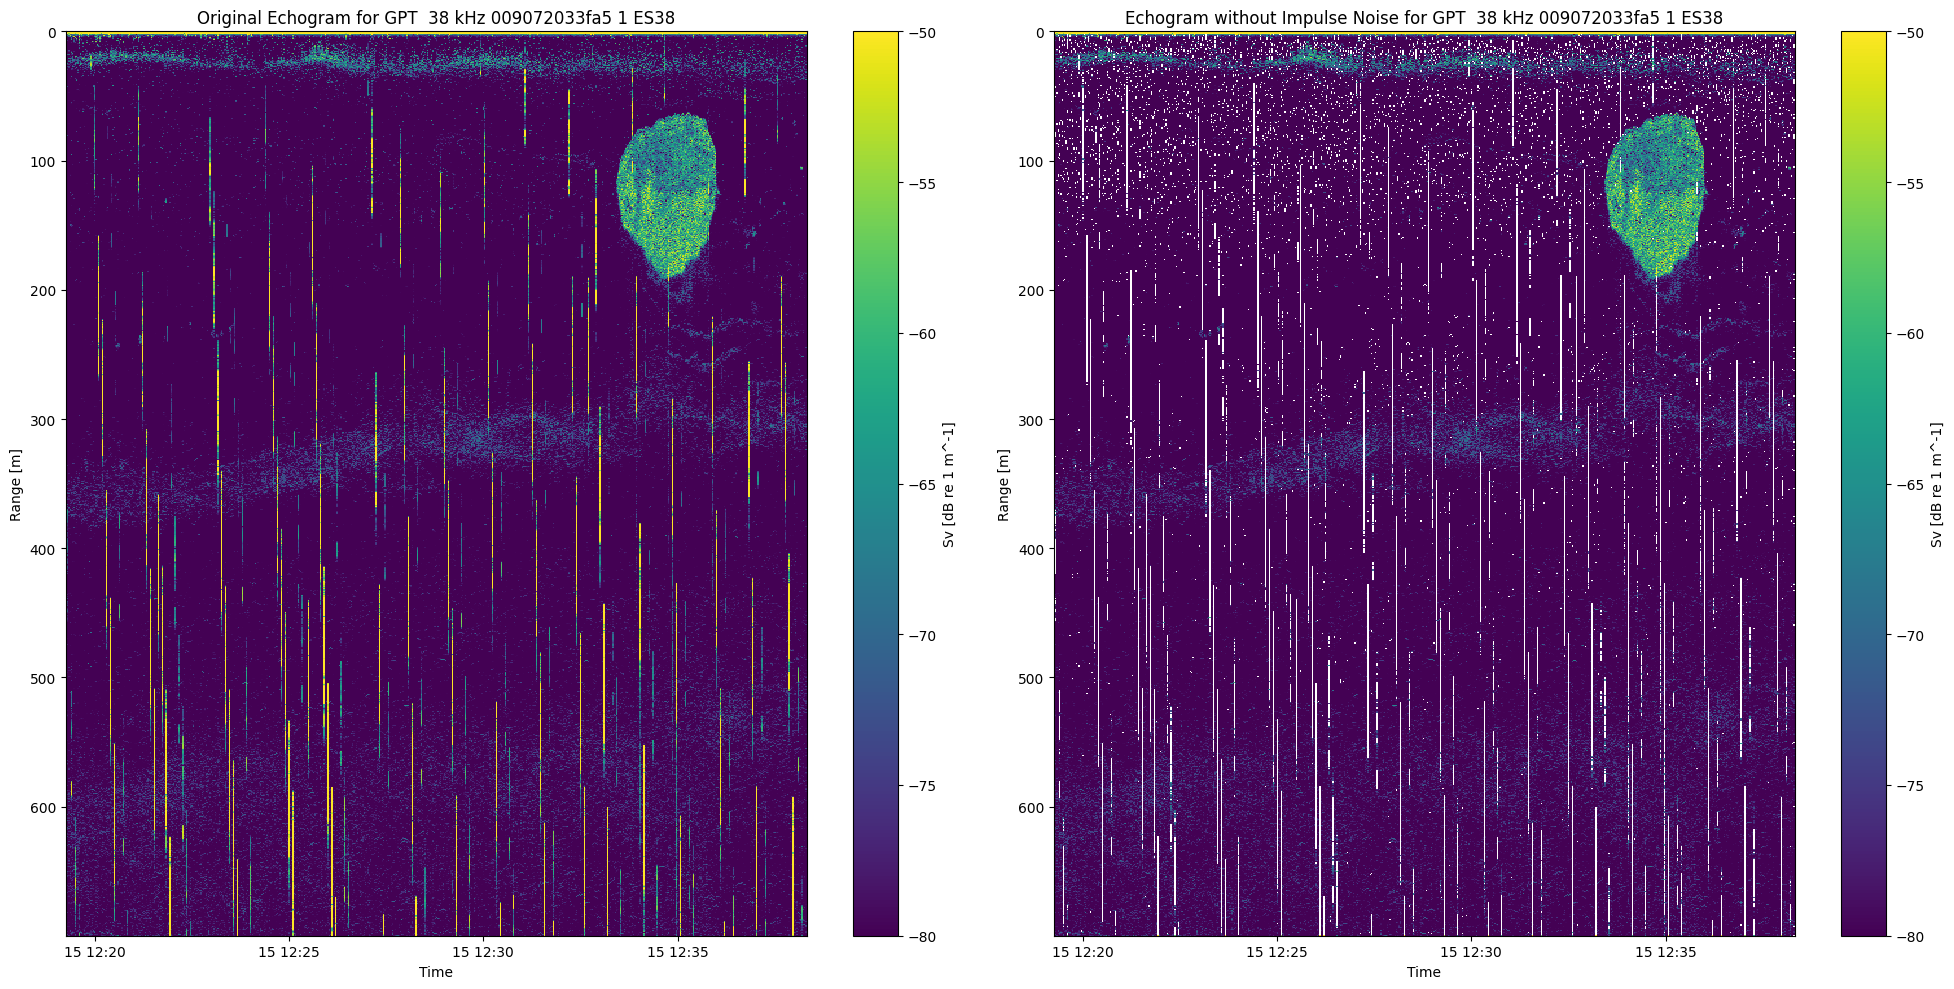

In [36]:
# Select the data from the desired channel
Sv_ds = source_Sv
vdesired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'
# Echogram for source_Sv
Sv = Sv_ds['Sv'].sel(channel=desired_channel)
ping_time = Sv_ds['ping_time']
range_sample = Sv_ds['echo_range'].sel(channel=desired_channel)

# Create a single figure for both echograms
plt.figure(figsize=(20, 10)) 

# Create the first echogram (original Sv)
plt.subplot(1, 2, 1)
plt.pcolormesh(ping_time, range_sample.T, Sv.T, cmap='viridis', vmin=-80, vmax=-50)
plt.gca().invert_yaxis()
plt.colorbar(label='Sv [dB re 1 m^-1]')
plt.ylabel('Range [m]')
plt.xlabel('Time')
plt.title(f'Original Echogram for {desired_channel}')

# Echogram for Sv_in (after applying mask)
Sv = Sv_in['Sv'].sel(channel=desired_channel)
ping_time = Sv_in['ping_time']
range_sample = Sv_in['echo_range'].sel(channel=desired_channel)

# Create the second echogram (Sv without impulse noise)
plt.subplot(1, 2, 2)
plt.pcolormesh(ping_time, range_sample.T, Sv.T, cmap='viridis', vmin=-80, vmax=-50)
plt.gca().invert_yaxis()
plt.colorbar(label='Sv [dB re 1 m^-1]')
plt.ylabel('Range [m]')
plt.xlabel('Time')
plt.title(f'Echogram without Impulse Noise for {desired_channel}')

plt.tight_layout()
plt.show()


In [37]:
ds_Sv = add_depth(add_location(Sv_in, ed, nmea_sentence="GGA"))
cell_dist = 0.1
cell_depth = 230
ds_NASC = compute_NASC(ds_Sv, cell_dist, cell_depth)

dist_nmi = get_distance_from_latlon(ds_Sv)


In [38]:
ds_NASC

<xarray.Dataset>
Dimensions:            (channel: 3, distance: 41, depth: 4)
Coordinates:
  * channel            (channel) object 'GPT  38 kHz 009072033fa5 1 ES38' ......
  * distance           (distance) float64 0.0 0.1 0.2 0.3 ... 3.7 3.8 3.9 4.0
  * depth              (depth) float64 0.0 230.0 460.0 690.0
Data variables:
    NASC               (channel, distance, depth) float64 0.9218 ... 17.06
    frequency_nominal  (channel) float64 3.8e+04 1.2e+05 2e+05
Attributes:
    Conventions:          CF-1.7,ACDD-1.3
    time_coverage_start:  2009-12-15T12:19:16.311000064Z
    time_coverage_end:    2009-12-15T12:38:18.312000000Z
    geospatial_lat_min:   -59.1564
    geospatial_lat_max:   -59.10194
    geospatial_lon_min:   -44.6762
    geospatial_lon_max:   -44.60151

In [39]:
ds_NASC['NASC'].values.shape

(3, 41, 4)

In [40]:
ds_NASC['NASC'].values.max()

72.42021284363656